# Sally's MCMC method to cluster time series trajectories  
This is a gentle intro to using MCMC (Monte Carlo Markov Chains), which quite frankly is magic as far as I'm concerned but the concepts and maths are pretty easy to follow. (Apologies in advance for the Matlab code but it is easier to read than my numpy code)

#### Let's start with simulated data

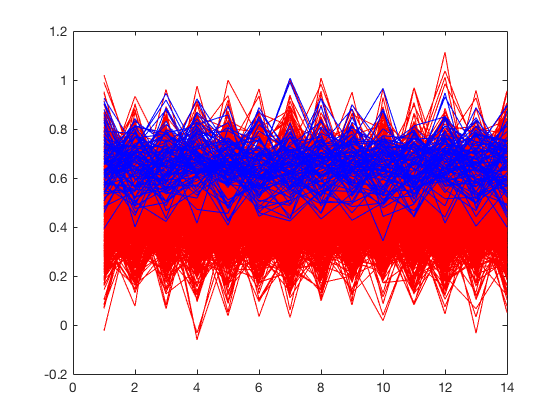

In [1]:
%% Generate data
clear variables
n = 1000; % number of timeseries (samples)
ntime = 14; % number of time points in the time series
y = zeros(n,ntime); % y will hold our data (n timeseries)
prob_true = 0.9; % proportion of timeseries in group2 (mu2, sigma2)
u = rand(n,1);

% draw the samples for group1 from a normal distribution 
kk1 = find(u > prob_true);
mu1_true = 0.65;
sigma1_true = 0.10;
y(kk1,:)=normrnd(mu1_true,sigma1_true,length(kk1),ntime);

% draw the samples for group2 from a normal distribution 
kk2 = find(u < prob_true);
mu2_true = 0.5;
sigma2_true = 0.15;
y(kk2,:) = normrnd(mu2_true, sigma2_true, length(kk2), ntime);

% plot the generated timeseries
time=linspace(1, ntime, ntime)';
figure
plot(time,y(kk2,:),'r');
hold on
plot(time,y(kk1,:),'b');
hold off

## MCMC rationale  

We want to know the group membership $\gamma_k$ of each individual $y$: where $Pr(\gamma_k=j)$ is the probability that an individual $k$'s time series $y_{k}$ belongs to group $j$. Let's express this as the probability of observing $y_k$ given $\gamma_k: Pr(y_k \mid \gamma_k=j)$  
  
Now we can begin with a simplified assumption that $\gamma_k \sim\mathcal{N}(\mu_j, \sigma_j^2)$ 
...this simple starting assumption will be incrementally improved in time.
**(Note to Sally: Is $\gamma_k$ our model $\mathcal{M}$, and parameters $\mu, \sigma^2$ then $\theta$?)**
  
With these parameters, the likelihood function of observing $y_k$ is: 
  
$$
\mathcal{L}(y_k \mid \mu, \sigma^2, \gamma_k = j)
$$
  
Where
  
$\mu = (\mu_1, \mu_2)$ is uniform and improper  
  
$\sigma^2 = (\sigma_1^2, \sigma_2^2)Pr(\sigma_j^2) \propto \frac{1} {\sigma^2}$
  
 and $ \gamma_1 \sim Be(\pi)$ where $Pr(\gamma_l = 1) = \pi$ and $\pi \sim U[0,1]$
  
  
We want to explore the joint posterior (which is given by Bayes Rule):
  
$$
\begin{equation*}
Pr(\gamma, \mu, \sigma^2 \mid y) = \frac{Pr(y \mid (\gamma, \mu, \sigma^2) \ \ Pr((\gamma, \mu, \sigma^2)} {Pr(y)}
\end{equation*}
$$
  
Since this has no closed form solution, we must use MCMC to randomly sample $\gamma$, $\mu$ and $\sigma^2$ from $Pr(\gamma, \mu, \sigma^2 \mid y)$ and thus calculate the joint posterior.  
  
We can then update the probability of $\gamma$ according to $Be(\pi)$:  
   
  
The posterior serves as the prior for the next iteration, adjusted by a random threshold. This is the Markov step in the MCMC scheme

#### MCMC scheme

In [2]:
%%file mcmc.m
function [ind_iter] = mcmc(y)
    % Initializing values for MCMC
    n = size(y, 1); % update n
    nloop = 10000; % number of iterations
    nwarmup = 5000;
    ind_iter = ones(n, nloop+1); % index for group membership in each loop
    u = rand(n, 1); % random starting value for proportion assumed in group2
    kk = u < 0.5; % find the index of each group member 
    ind_iter(kk, 1) = 2; % update the first index with starting group

    mu_iter = zeros(2, nloop+1); % to store the mu in each loop 
    mu_iter(1, 1) = mean(mean(y(kk, :), 2)); % mu of group1 to start
    mu_iter(2, 1) = mean(mean(y(~kk, :), 2)); % mu of group2 to start

    sigmasq_iter = zeros(2, nloop+1); % to store sigmasq in each loop
    temp = y(kk, :);
    sigmasq_iter(1, 1) = var(temp(:));
    temp = y(~kk, :);
    sigmasq_iter(2, 1) = var(temp(:));

    prior_prob_iter = 0.5 * ones(2, nloop+1); % priors
    post_prob_iter = 0.5 * ones(n, 2, nloop+1); % posteriors

    % Starting MCMC scheme
    for p = 1:nloop

        % Drawing mu and sigma
        for j = 1:2 % for each group (1 and 2)

            % find the current group scores
            kk = ind_iter(:,p) == j;
            temp = y(kk, :);
            temp = temp(:);

            % draw a random mu and sigma from the same distribution 
            mu_iter(j, p+1) = normrnd(mean(temp), ...
                sqrt(sigmasq_iter(j,p) / length(temp)));
            sig_a = length(temp) / 2; % shape and scale parameters for gamma
            sig_b = sum((temp-ones(length(temp), 1) * mu_iter(j, p+1)).^2) / 2;
            sigmasq_iter(j, p+1) = 1 ./ gamrnd(sig_a, 1/sig_b);
        end

        % Evaluate the likelihood the data was drawn from a distribution with 
        % that new (random) mu and sigma
        like = zeros(n, 2);
        for j = 1:2 % for each group (1 and 2)
            % Calculate the likelihood of each timeseries in each distribution
            like(:,j) = prod(...
                             normpdf(...
                                     y(:,:), ...
                                     mu_iter(j, p+1), ... % new mu
                                     sqrt(sigmasq_iter(j, p+1))... % new sigma
                                     ),...
                             2); % take the product of each row (timeseries)
            % (like is likelihood score for each timeseries)
            %
            % numerator for Bayes rule:   
            numer(:,j) = like(:, j) .* ones(n, 1) * prior_prob_iter(j, p);
        end

        % denominator for Bayes rule:
        denom = sum(numer, 2);

        % Calculate the posterior (Bayes rule)
        for j=1:2
            post_prob_iter(:, j, p+1) = numer(:, j) ./ denom;
        end

        % Update the group membership acccording to the posterior for each group
        u = rand(n, 1); % random threshold (why does this work???)
        kk = post_prob_iter(:, j, p+1) < u;
        ind_iter(kk, p+1) = 1;
        ind_iter(~kk, p+1) = 2;

        % Update the prior for each group <Slot in Davids code about here>
        prior_prob_iter(1, p+1) = betarnd(sum(kk), n-sum(kk));
        prior_prob_iter(2, p+1) = 1 - prior_prob_iter(1, p+1);

    end
end

Created file '/Users/rich/Dropbox/RichardSallyNickTrajModels/results/mcmc.m'.


In [3]:
ind_iter = mcmc(y);

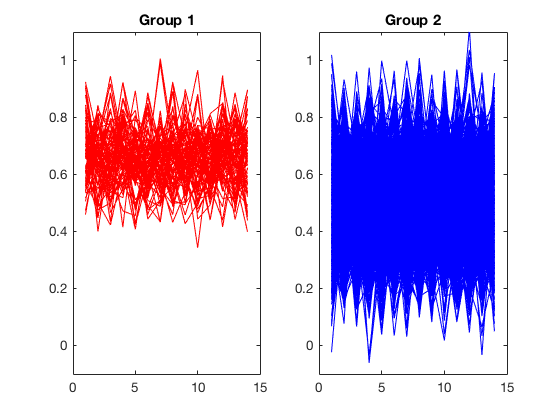

In [5]:
%% plot the revealed groups
time=linspace(1, ntime, ntime)';
idx = ind_iter(:, end) == 1;
figure
subplot(1,2,1)
plot(time,y(idx,:),'r');
ylim([-.1 1.1])
xlim([0 15])
title('Group 1')
subplot(1,2,2)
plot(time,y(~idx,:),'b');
ylim([-.1 1.1])
xlim([0 15])
title('Group 2')

In [ ]:
%% Trace plots
figure
subplot(2,2,1)
plot(mu_iter(1,:))
%ylim([0 100])
title('mu1')
subplot(2,2,2)
plot(mu_iter(2,:))
%ylim([0 100])
title('mu2')
subplot(2,2,3)
plot(sqrt(sigmasq_iter(1,:)))
%ylim([5 20])
title('sigma1')
subplot(2,2,4)
plot(sqrt(sigmasq_iter(2,:)))
%ylim([5 20])
title('sigma2')

#### Conclusions from simulated data:  
Two groups are recovered (which is not surprising since we only allowed for two groups in the algorithm). Accuracy and specificity tests to be done.

## Now let's try some real data (MH-I5 scores from HILDA)

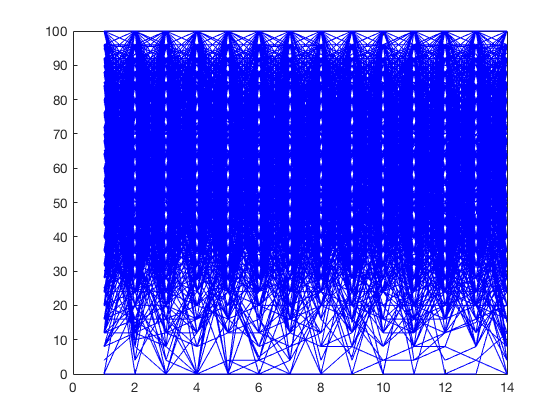

In [6]:
%% ...Or load the mental health scores from HILDA
run('../import_ghmhcleancsv.m')
y = ghmh;
plot(time, y, 'b')

In [7]:
ind_iter = mcmc(y);

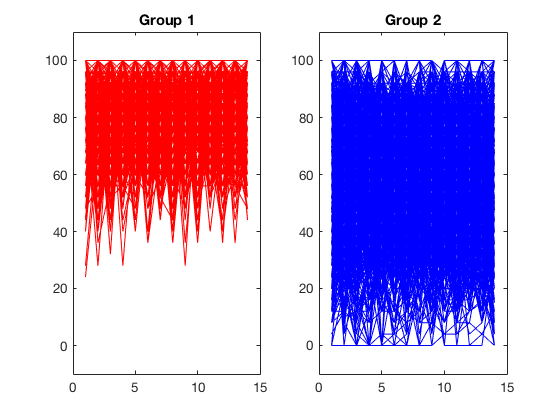

In [9]:
%% plot the revealed groups
time=linspace(1, ntime, ntime)';
idx = ind_iter(:, end) == 1;
figure
subplot(1,2,1)
plot(time,y(idx,:),'r');
ylim([-10 110])
xlim([0 15])
title('Group 1')
subplot(1,2,2)
plot(time,y(~idx,:),'b');
ylim([-10 110])
xlim([0 15])
title('Group 2')

## Conclusions:  
Two groups are recovered. **Note that Group 1 (red) has a higher mean and less variance than Group 2 (blue), consistent with a** ***superwell group***. Presumably this occured by chance, since we haven't provided any restrictions to ensure this outcome (i.e., I don't know why this occurred!)

#### Compare to kmeans

In [13]:
idx = kmeans(y, 2);

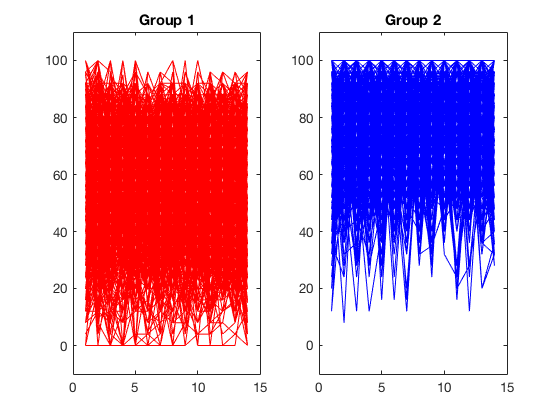

In [18]:
%% plot the revealed groups
time=linspace(1, ntime, ntime)';
idx = idx == 1;
figure
subplot(1,2,1)
plot(time,y(idx,:),'r');
ylim([-10 110])
xlim([0 15])
title('Group 1')
subplot(1,2,2)
plot(time,y(~idx,:),'b');
ylim([-10 110])
xlim([0 15])
title('Group 2')